In [7]:
# Run this first cell
!pip install -q joblib   # usually preinstalled; safe to run
import pandas as pd, numpy as np, re, html
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib


In [13]:
!head -n 5 "/content/IMDB Dataset.csv"


review,sentiment
"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show

In [16]:
# Robust parser: reads raw file and extracts records ending with ",positive" or ",negative"
import re, pandas as pd, sys
path = "/content/IMDB Dataset.csv"   # change if needed

# 1) Read file as raw text (replace decode errors so we don't crash)
with open(path, "r", encoding="utf-8", errors="replace") as f:
    raw = f.read()

print("Raw file length (chars):", len(raw))

# 2) Regex: non-greedy capture of everything up to the last comma + sentiment,
# allowing the review to contain newlines and commas.
pattern = re.compile(r'(.*?),(positive|negative)(?:\r\n|\n|\r|$)', re.DOTALL)

matches = list(pattern.finditer(raw))
print("Regex matches found:", len(matches))

# If too few matches, print a small snippet to inspect and stop
if len(matches) < 10:
    print("\n⚠️ Few matches found — showing first 2000 chars for inspection:\n")
    print(raw[:2000])
    raise RuntimeError("Parsed too few records. The file format may be different or corrupted.")

# 3) Build rows and clean quotes
rows = []
for m in matches:
    review = m.group(1)
    sentiment = m.group(2)
    # Trim a leading header if present (e.g., the first match may include header names)
    rows.append((review, sentiment))

df = pd.DataFrame(rows, columns=["review", "sentiment"])

# 4) Clean up obvious quoting artifacts:
def normalize_text(s):
    s = s.strip()
    # remove surrounding double quotes if the whole review is quoted
    if len(s) >= 2 and s[0] == '"' and s[-1] == '"':
        s = s[1:-1]
    # turn doubled quotes into single quotes (CSV escaping)
    s = s.replace('""', '"')
    return s

df['review'] = df['review'].apply(normalize_text)

# 5) Quick checks
print("Parsed shape:", df.shape)
print("Example head (first 3 rows):")
print(df.head(3).to_string(index=False))

print("\nSentiment value counts (top rows):")
print(df['sentiment'].value_counts().head())

# 6) Save parsed CSV so you can inspect / reuse
out_parsed = "/content/imdb_parsed.csv"
df.to_csv(out_parsed, index=False)
print("\nSaved parsed file to:", out_parsed)

# 7) Optional: create balanced small sample (50 rows: 25 pos + 25 neg)
df = df.dropna(subset=['review','sentiment']).reset_index(drop=True)
pos = df[df['sentiment']=='positive']
neg = df[df['sentiment']=='negative']

# safety: ensure we have enough in each class
if len(pos) < 25 or len(neg) < 25:
    print(f"Not enough examples: pos={len(pos)}, neg={len(neg)}. Will sample what's available.")
    n_pos = min(25, len(pos))
    n_neg = min(25, len(neg))
else:
    n_pos, n_neg = 25, 25

small = pd.concat([pos.sample(n_pos, random_state=42), neg.sample(n_neg, random_state=42)])
small = small.sample(frac=1, random_state=42).reset_index(drop=True)
small_out = "/content/imdb_small_50.csv"
small.to_csv(small_out, index=False)
print("Saved balanced small sample to:", small_out)
print("small sample shape:", small.shape)
print(small['sentiment'].value_counts())




Raw file length (chars): 3145083
Regex matches found: 2417
Parsed shape: (2417, 2)
Example head (first 3 rows):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [17]:
# Drop missing rows just in case
df = df.dropna()

# Take 25 positive + 25 negative
pos = df[df['sentiment'] == 'positive'].sample(25, random_state=42)
neg = df[df['sentiment'] == 'negative'].sample(25, random_state=42)

small_df = pd.concat([pos, neg]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save to new CSV
small_df.to_csv("/content/imdb_small_50.csv", index=False)
print("Saved shape:", small_df.shape)
print(small_df['sentiment'].value_counts())
small_df.head(3)


Saved shape: (50, 2)
sentiment
positive    25
negative    25
Name: count, dtype: int64


,review,sentiment
0,The year 2005 saw no fewer than 3 filmed produ...,positive
1,Mario Lewis of the Competitive Enterprise Inst...,negative
2,The idea behind this movie was great. The stor...,negative


In [18]:
import pandas as pd

path = "/content/imdb_small_50.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
print(df['sentiment'].value_counts())
df.head(3)


Shape: (50, 2)
sentiment
positive    25
negative    25
Name: count, dtype: int64


,review,sentiment
0,The year 2005 saw no fewer than 3 filmed produ...,positive
1,Mario Lewis of the Competitive Enterprise Inst...,negative
2,The idea behind this movie was great. The stor...,negative


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('review').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('review')):
  _plot_series(series, series_name, i)
  fig.legend(title='review', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('sentiment')):
  _plot_series(series, series_name, i)
  fig.legend(title='sentiment', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['sentiment'].value_counts()
    for x_label, grp in _df_6.groupby('review')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('review')
_ = plt.ylabel('sentiment')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['review'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='index', y='review', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='sentiment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [19]:
import re, html

def clean_text(s):
    s = str(s)
    s = html.unescape(s)                     # decode HTML entities
    s = re.sub(r'<.*?>', ' ', s)             # remove HTML tags
    s = re.sub(r"n['’]t\b", " not", s)       # expand contractions
    s = re.sub(r"['’]re\b", " are", s)
    s = re.sub(r"['’]s\b", " is", s)
    s = re.sub(r"['’]ve\b", " have", s)
    s = re.sub(r"['’]ll\b", " will", s)
    s = re.sub(r"['’]d\b", " would", s)
    s = re.sub(r"['’]m\b", " am", s)
    s = re.sub(r'[^A-Za-z0-9\s]', ' ', s)    # remove punctuation
    s = s.lower()
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['clean_review'] = df['review'].apply(clean_text)
df[['review','clean_review']].head(3)


,review,clean_review
0,The year 2005 saw no fewer than 3 filmed produ...,the year 2005 saw no fewer than 3 filmed produ...
1,Mario Lewis of the Competitive Enterprise Inst...,mario lewis of the competitive enterprise inst...
2,The idea behind this movie was great. The stor...,the idea behind this movie was great the story...


In [20]:
from sklearn.model_selection import train_test_split

X = df['clean_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", len(X_train), "Test size:", len(X_test))


Train size: 40 Test size: 10


In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

pipe = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2), max_features=1000),
    LogisticRegression(solver="liblinear", random_state=42)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6
              precision    recall  f1-score   support

    negative       0.57      0.80      0.67         5
    positive       0.67      0.40      0.50         5

    accuracy                           0.60        10
   macro avg       0.62      0.60      0.58        10
weighted avg       0.62      0.60      0.58        10



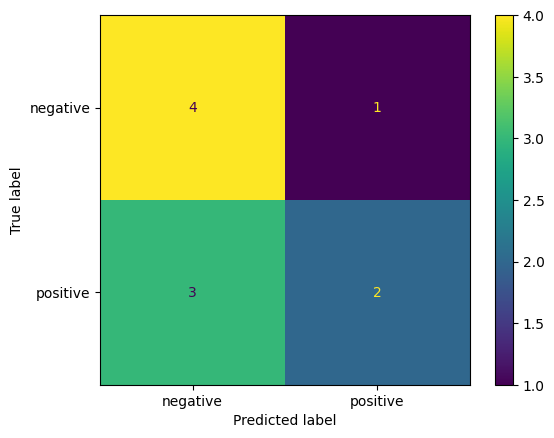

Misclassified reviews:
                                               review      true      pred
18  im the type of person who always goes 2 to hor...  negative  positive
47  cute idea salesgirl linda smith yolande donlan...  positive  negative
22  i was surprised that forgiving the franklins d...  positive  negative


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=['negative','positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])
disp.plot()
plt.show()

errors = pd.DataFrame({"review": X_test, "true": y_test, "pred": y_pred})
print("Misclassified reviews:")
print(errors[errors['true'] != errors['pred']].head(3))


In [23]:
vec = pipe.named_steps['tfidfvectorizer']
clf = pipe.named_steps['logisticregression']
feature_names = vec.get_feature_names_out()
coefs = clf.coef_[0]

top_pos = sorted(zip(coefs, feature_names), reverse=True)[:10]
top_neg = sorted(zip(coefs, feature_names))[:10]

print("Top positive words:")
print(top_pos)
print("\nTop negative words:")
print(top_neg)


Top positive words:
[(np.float64(0.477749285202596), 'it'), (np.float64(0.26153593695650895), 'was'), (np.float64(0.25631307093197514), 'yet'), (np.float64(0.25596155388552516), 'very'), (np.float64(0.22536636680283012), 'in'), (np.float64(0.2160720640699566), 'chick'), (np.float64(0.2053956475451283), 'it is'), (np.float64(0.20344316017485678), 'love'), (np.float64(0.1988789614246853), 'her'), (np.float64(0.19049621511416984), 'great')]

Top negative words:
[(np.float64(-0.476935414420019), 'the'), (np.float64(-0.2511774876803783), 'zombie'), (np.float64(-0.20385203964007861), 'actors'), (np.float64(-0.2033219419473489), 'for'), (np.float64(-0.18803394738690923), 'their'), (np.float64(-0.1860452775658559), 'mind'), (np.float64(-0.18595736043197145), 'if'), (np.float64(-0.18322330949083773), 'movie is'), (np.float64(-0.18064354055880202), 'point'), (np.float64(-0.17467581158241632), 'with')]


In [24]:
import joblib
joblib.dump(pipe, "/content/imdb_sentiment_model.joblib")
print("Model saved as imdb_sentiment_model.joblib")


Model saved as imdb_sentiment_model.joblib
